
# Information Conditions - Environmental State and Action Histories

> Plot learning trajectories under different information conditions of the Ecological Public Goods Game. a) Only environmental state history observable, b) only action history is observable, c) both environmental state and action histories are observable d) No information


In [23]:
%pip install nbimporter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import copy

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood

from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Agents.POStrategyActorCritic_eps import POstratAC_eps



from pyCRLD.Utils import FlowPlot as fp
from fastcore.utils import *
from jax import jit
import jax.numpy as jnp
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

from scipy.stats import kstest

from scipy.stats import qmc
import itertools as it
import pandas as pd

global_seed = 40
np.random.seed(global_seed)

%run "./helper_functions.ipynb" import lhs_sampling
%run "./helper_functions.ipynb" import get_unique_arrays

In [25]:

ecopg = EcologicalPublicGood(N=2, f=1.2, c=5, m=-6, qc=0.02, qr= 0.0001, degraded_choice=True)
ecopg_with_history = HistoryEmbedded(ecopg, h = (1,1,1))

In [26]:
# np.set_printoptions(precision=4, suppress= True)


Complete state and action information - Monte Carlo analysis

In [28]:
def get_average_cooperativeness_postratAC(policy, obsdist):

        
    policy_cooperation_probabilities = policy[:,:, 0]
    agent_index, state_index = [0, 1]

    average_cooperation_for_each_agent = jnp.einsum(policy_cooperation_probabilities, [agent_index, state_index], obsdist, [agent_index, state_index], [agent_index])
    
    return average_cooperation_for_each_agent


def get_average_cooperativeness_stratAC(policy, state_dist):

    policy_cooperation_probabilities = policy[:,:, 0]
    agent_index, state_index = [0, 1]

    average_cooperation_for_each_agent = jnp.einsum(policy_cooperation_probabilities, [agent_index, state_index], state_dist, [state_index], [agent_index])
    
    return average_cooperation_for_each_agent

Extracting Final Strategies

In [30]:
global_seed = 42

socdi = SocialDilemma(R=1.0, T=1.2, S=-0.5, P=0.0)
memo1pd = HistoryEmbedded(socdi, h = (1, 1, 1))

In [31]:
mae_strat = stratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
mae_postrat = POstratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
mae_postrat_eps = POstratAC_eps(env=memo1pd, learning_rates=0.1, discount_factors=0.9)

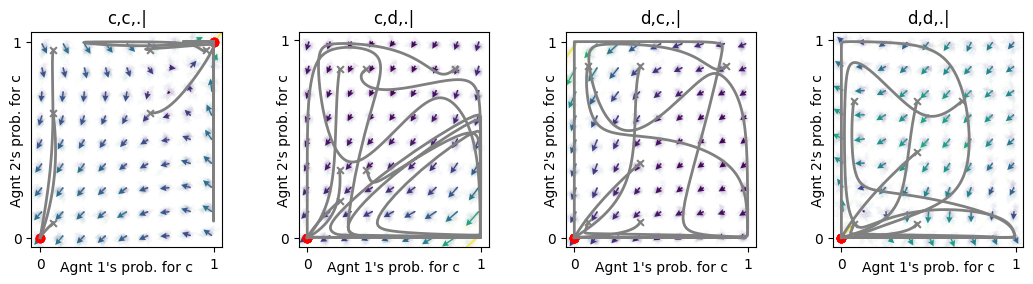

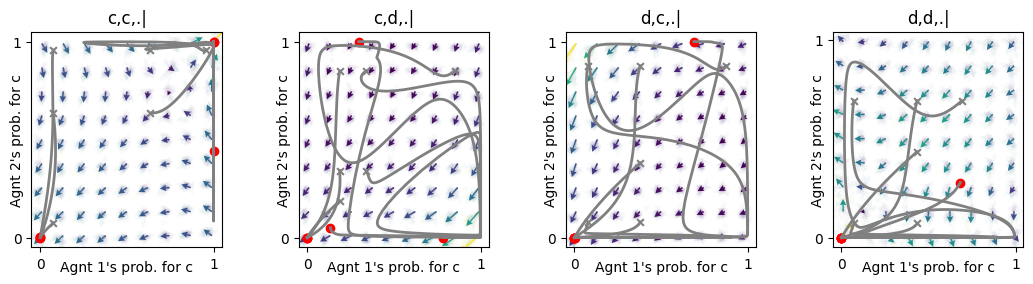

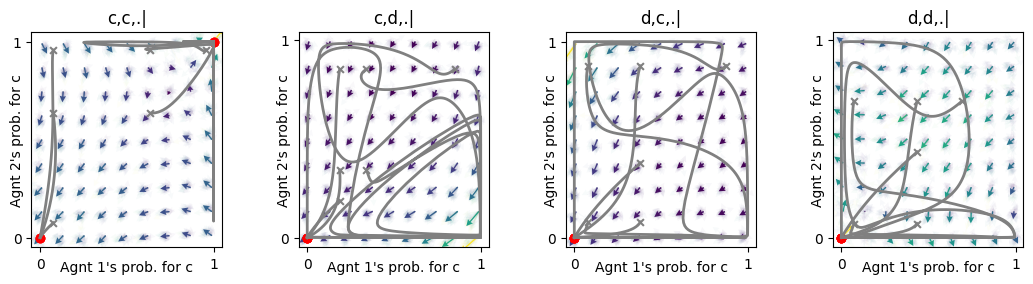

In [32]:
# Initialize the information condition

# Generate initial conditions using Latin hypercube sampling
num_samples = 3

initial_conditions_list = lhs_sampling(mae_strat.Q, num_samples, mae_strat.N)  #same initial condition for both

x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])

ax_stratAC = fp.plot_strategy_flow(mae_strat, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32, conds = mae_strat.env.Oset[0])
ax_POstratAC = fp.plot_strategy_flow(mae_postrat, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32, conds = mae_postrat.env.Oset[0])
ax_POstratAC_eps = fp.plot_strategy_flow(mae_postrat_eps, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32, conds = mae_postrat_eps.env.Oset[0])
# Store unique points for this mode

xtraj_stratAC_list = []
xtraj_postratAC_list = []
xtraj_postratAC_eps_list = []

final_point_list_stratAC = []
final_point_list_postratAC = []
final_point_list_postratAC_eps = []

# Monte Carlo Simulations
for initial_condition in initial_conditions_list:


    '''stratAC'''
    xtraj_stratAC, fixedpointreached_stratAC = mae_strat.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    final_point_stratAC = xtraj_stratAC[-1]
    xtraj_stratAC_list.append(xtraj_stratAC)

    fp.plot_trajectories([xtraj_stratAC], x, y, cols=['grey'], lss = "--", axes = ax_stratAC) #plot the trajectory

    final_point_list_stratAC.append(final_point_stratAC)
    
    for plot_index, (x_indices,y_indicies) in enumerate(zip(it.product(*x), it.product(*y))):   #plot the final point
        ax_stratAC[plot_index].scatter(final_point_stratAC[x_indices],final_point_stratAC[y_indicies], color = 'red')
    

    '''POstratAC'''


    xtraj_postratAC, fixedpointreached_postratAC = mae_postrat.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    final_point_postratAC = xtraj_postratAC[-1]

    xtraj_postratAC_list.append(xtraj_postratAC)


    fp.plot_trajectories([xtraj_postratAC], x, y, cols=['grey'], lss = "--", axes = ax_POstratAC)

    final_point_list_postratAC.append(final_point_postratAC)


    
    for plot_index, (x_indices,y_indicies) in enumerate(zip(it.product(*x), it.product(*y))):
        ax_POstratAC[plot_index].scatter(final_point_postratAC[x_indices],final_point_postratAC[y_indicies], color = 'red')

    '''POstratAC_eps'''


    xtraj_postratAC_eps, fixedpointreached_postratAC_eps = mae_postrat_eps.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    final_point_postratAC_eps = xtraj_postratAC_eps[-1]

    xtraj_postratAC_eps_list.append(xtraj_postratAC_eps)


    fp.plot_trajectories([xtraj_postratAC_eps], x, y, cols=['grey'], lss = "--", axes = ax_POstratAC_eps)

    final_point_list_postratAC_eps.append(final_point_postratAC_eps)


    
    for plot_index, (x_indices,y_indicies) in enumerate(zip(it.product(*x), it.product(*y))):
        ax_POstratAC_eps[plot_index].scatter(final_point_postratAC_eps[x_indices],final_point_postratAC_eps[y_indicies], color = 'red')







In [ ]:
# Initialize the information condition
mae_strat = stratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.99)
mae_postrat = POstratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.99)
mae_postrat_eps = POstratAC_eps(env=memo1pd, learning_rates=0.1, discount_factors=0.99)
# Generate initial conditions using Latin hypercube sampling
num_samples = 10

initial_conditions_list = lhs_sampling(mae_strat.Q, num_samples, mae_strat.N)  #same initial condition for both

x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])


# Store unique points for this mode

xtraj_stratAC_list = []
xtraj_postratAC_list = []
xtraj_postratAC_eps_list = []

final_point_list_stratAC = []
final_point_list_postratAC = []
final_point_list_postratAC_eps = []

final_cooperation_list_stratAC = []
final_cooperation_list_postratAC = []
final_cooperation_list_postratAC_eps = []

# Monte Carlo Simulations
for initial_condition in initial_conditions_list:


    '''stratAC'''
    xtraj_stratAC, fixedpointreached_stratAC = mae_strat.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    xtraj_stratAC_list.append(xtraj_stratAC)


    final_point_stratAC = xtraj_stratAC[-1]
    final_point_list_stratAC.append(final_point_stratAC)

    final_cooperation_stratAC = np.mean(get_average_cooperativeness_stratAC(final_point_stratAC,  mae_strat.Ps(final_point_stratAC)))
    final_cooperation_list_stratAC.append(final_cooperation_stratAC)
    
    '''POstratAC'''


    xtraj_postratAC, fixedpointreached_postratAC = mae_postrat.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    xtraj_postratAC_list.append(xtraj_postratAC)

    final_point_postratAC = xtraj_postratAC[-1]
    final_point_list_postratAC.append(final_point_postratAC)

    final_cooperation_postratAC = np.mean(get_average_cooperativeness_postratAC(final_point_postratAC,  mae_postrat.obsdist(final_point_postratAC)))
    final_cooperation_list_postratAC.append(final_cooperation_postratAC)

    '''POstratAC_eps'''

    xtraj_postratAC_eps, fixedpointreached_postratAC_eps = mae_postrat_eps.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    xtraj_postratAC_eps_list.append(xtraj_postratAC_eps)

    final_point_postratAC_eps = xtraj_postratAC_eps[-1]
    final_point_list_postratAC_eps.append(final_point_postratAC_eps)

    final_cooperation_postratAC_eps = np.mean(get_average_cooperativeness_postratAC(final_point_postratAC_eps,  mae_postrat_eps.obsdist(final_point_postratAC_eps)))
    final_cooperation_list_postratAC_eps.append(final_cooperation_postratAC_eps)

cleaner_final_cooperation_list_stratAC = np.array([round(float(x),3) for x in final_cooperation_list_stratAC])
cleaner_final_cooperation_list_postratAC = np.array([round(float(x),3) for x in final_cooperation_list_postratAC])
cleaner_final_cooperation_list_postratAC_eps = np.array([round(float(x),3) for x in final_cooperation_list_postratAC_eps])

# print("Final Cooperation vals stratac", np.sum(cleaner_final_cooperation_list_stratAC > 0.7))
# print("Final Cooperation vals postratac", np.sum(cleaner_final_cooperation_list_postratAC > 0.7))
# print("Final Cooperation vals postratac_eps", np.sum(cleaner_final_cooperation_list_postratAC_eps > 0.7))

print("Final points for stratAC:", get_unique_arrays(np.round(final_point_list_stratAC,3)))
print("Final points for postratAC:", get_unique_arrays(np.round(final_point_list_postratAC,3)))
print("Final points for postratAC_eps:", get_unique_arrays(np.round(final_point_list_postratAC_eps,3)))







Final points for stratAC: [array([[[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]]), array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]]), array([[[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]],

       [[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]]), array([[[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]]])]
Final points for postratAC: [array([[[1.   , 0.   ],
        [0.639, 0.361],
        [0.03 , 0.97 ],
        [0.002, 0.998]],

       [[1.   , 0.   ],
        [0.572, 0.428],
        [0.008, 0.992],
        [0.002, 0.998]]]), array([[[0.114, 0.886],
        [0.   , 1.   ],
        [0.001, 0.999],
        [0.   , 1.   ]],

       [[0.005, 0.995],
        [0.   , 1.   ],
     

In [34]:
'''Estimating where the trajectories of POstratAC and stratAC differ'''

traj_differs_at = None

for i in range(xtraj_postratAC.shape[0]):   
    if not np.array_equal(xtraj_postratAC[i, :, :, :], xtraj_stratAC[i, :, :, :]):
        print('stratAC and POstratAc traj differs at ', i)
        traj_differs_at = i
        break   

# print(xtraj_postratAC[i , :, :, :] - xtraj_stratAC[i , :, :, :])



stratAC and POstratAc traj differs at  152


In [35]:
'''Seeing what happens to the transition probabilities when the trajectories differ'''

print(mae_postrat.Tioo(xtraj_postratAC[i -1, :, :, :])[0], "POstratc Tioo")
print(mae_postrat.Tss(xtraj_postratAC[i -1, :, :, :]), "Postat Tss")

print(mae_strat.Tss(xtraj_postratAC[i -1 , :, :, :]), "Strat Tss")

print(mae_postrat.Tioo(xtraj_postratAC[i -1, :, :, :])[0] - mae_strat.Tss(xtraj_postratAC[i -1 , :, :, :]), "diff")


[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [4.6096594e-07 4.0468533e-04 1.1373155e-03 9.9845761e-01]
 [4.2444553e-06 1.1754119e-03 3.5937999e-03 9.9522656e-01]
 [9.2565938e-07 5.6624314e-04 1.6311449e-03 9.9780178e-01]] POstratc Tioo
[[1.5433724e-08 7.6867946e-05 2.0072657e-04 9.9972242e-01]
 [4.6096594e-07 4.0468533e-04 1.1373155e-03 9.9845761e-01]
 [4.2444553e-06 1.1754119e-03 3.5937999e-03 9.9522656e-01]
 [9.2565938e-07 5.6624314e-04 1.6311449e-03 9.9780178e-01]] Postat Tss
[[1.5433724e-08 7.6867946e-05 2.0072657e-04 9.9972242e-01]
 [4.6096594e-07 4.0468533e-04 1.1373155e-03 9.9845761e-01]
 [4.2444553e-06 1.1754119e-03 3.5937999e-03 9.9522656e-01]
 [9.2565938e-07 5.6624314e-04 1.6311449e-03 9.9780178e-01]] Strat Tss
[[-1.5433724e-08 -7.6867946e-05 -2.0072657e-04 -9.9972242e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]] d

In [36]:
'''Beliefs when the trajectories differ'''

statedist_postratac_just_before_deviation = mae_postrat.Ps(xtraj_postratAC[i -1, :, :, :])

mae_postrat._bios(xtraj_postratAC[i -1, :, :, :], statedist_postratac_just_before_deviation)


Array([[[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]], dtype=float32)

In [37]:

'''Difference beween stationary probabilitie'''

# for i in range(xtraj_postratAC.shape[0]):
#     if not np.array_equal(mae_postrat.obsdist(xtraj_postratAC[i, :, :, :])[0], mae_strat.Ps(xtraj_stratAC[i, :, :, :])):
#         print(i)
#         break   


# print(xtraj_postratAC.shape[0], "length of the trajectory POstratAC")
# print(xtraj_stratAC.shape[0], "length of the trajectory stratAC")



for i in range(xtraj_postratAC.shape[0]):
    if not np.array_equal(mae_postrat.obsdist(xtraj_postratAC[i, :, :, :])[0], mae_postrat.Ps(xtraj_stratAC[i, :, :, :])):
        print('the obsdist and stat dist differs from',i)
        break   




# np.set_printoptions(precision = 9, suppress= True)




# print("the X value at ", traj_differs_at,  " for postratAC is ", xtraj_postratAC[172, :, :, :])
print("the  StateDist of stratac just before deviation point", mae_strat.Ps(xtraj_stratAC[ traj_differs_at -1 , :, :, :]))
print("the  StateDist of postratac just before deviation point", mae_strat.Ps(xtraj_postratAC[ traj_differs_at -1 , :, :, :]))
print("the  Obdsist of postratac just before deviation point", mae_postrat.obsdist(xtraj_postratAC[traj_differs_at -1, :, :, :])[0])
print("the  Obdsist of postratac_eps just before deviation point", mae_postrat_eps.obsdist(xtraj_postratAC_eps[traj_differs_at -1, :, :, :])[0])

print(mae_strat.Ps(xtraj_stratAC[ traj_differs_at -1 , :, :, :]) - mae_postrat.obsdist(xtraj_postratAC[traj_differs_at -1, :, :, :])[0])



the obsdist and stat dist differs from 151
the  StateDist of stratac just before deviation point [0.0000000e+00 5.6715083e-04 1.6340718e-03 9.9779880e-01]
the  StateDist of postratac just before deviation point [0.0000000e+00 5.6715083e-04 1.6340718e-03 9.9779880e-01]
the  Obdsist of postratac just before deviation point [0.0000000e+00 5.6715211e-04 1.6340718e-03 9.9779880e-01]
the  Obdsist of postratac_eps just before deviation point [0.0000000e+00 5.6715083e-04 1.6340718e-03 9.9779880e-01]
[ 0.0000000e+00 -1.2805685e-09  0.0000000e+00  0.0000000e+00]
